In [1]:
# in my mac environment, a Python 3.8.0 vesion should be used.
import sys
sys.version

'3.8.0 (default, Nov  6 2019, 15:49:01) \n[Clang 4.0.1 (tags/RELEASE_401/final)]'

In [61]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolor

from datetime import datetime

from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const
import sunpy.coordinates
from sunpy.coordinates import frames
import sunpy.map

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pfsspy
from pfsspy import tracing
# from pfsspy.sample_data import get_gong_map

In [62]:
def get_lon_loc_in_plot(lon, center_lon):
    lon_loc_in_plot = lon + (180-center_lon)
    if lon_loc_in_plot >= 360:
        return lon_loc_in_plot-360
    else:
        return lon_loc_in_plot
def set_axes_lims(ax):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 180)

In [63]:
from two_step_backmapping.two_step_ballistic_backmapping_method import *
R_SS_Rs = 2.5
nrho = 45 # Hou's setting
dir_data_PFSS = 'two_step_backmapping/PFSS_data/'

In [64]:
selected_events = pd.read_pickle('selected_events.pkl')

In [195]:
i_event = 44
# suitable for i_event in [44, 59]
t_start, t_end = selected_events.iloc[i_event][:2]
print(i_event,t_start,t_end)

43 2004-09-13 11:20:00 2004-09-13 11:32:00


In [196]:
t_middle = t_start + (t_start - t_end) / 2
t_event = t_middle.to_pydatetime()
R_earth = u.earthRad

WIND_pos_GSE = SkyCoord(x=selected_events['x_GSE_ACE'][i_event]* R_earth,
                        y=selected_events['y_GSE_ACE'][i_event]* R_earth,
                        z=selected_events['z_GSE_ACE'][i_event]* R_earth,
                        representation_type='cartesian',
                        frame=frames.GeocentricSolarEcliptic,
                        obstime=t_event,observer='earth')
WIND_pos_Carrington = WIND_pos_GSE.heliographic_carrington

r_begin_au = WIND_pos_Carrington.radius.to(u.AU).value
lon_begin_deg = WIND_pos_Carrington.lon.value
lat_begin_deg = WIND_pos_Carrington.lat.value
print(r_begin_au,lon_begin_deg,lat_begin_deg)

V_SW_r = -selected_events['V_proton_x_GSE_3DP'][i_event]

print(V_SW_r)

0.9964468499687923 18.001990835140365 7.199415733449091
317.69945447198273


In [197]:
%%time
r_footpoint_on_SourceSurface_rs, lon_footpoint_on_SourceSurface_deg, lat_footpoint_on_SourceSurface_deg, \
MFL_photosphere_lon_deg, MFL_photosphere_lat_deg, filename_out = \
two_step_backmapping(t_event, r_begin_au, lat_begin_deg, lon_begin_deg, V_SW_r, R_SS_Rs, dir_data_PFSS)
print('----------------------------------')
print('frame: Carrington')
print('SS [Rs] lon_on_SS [deg] lat_on_SS [deg] lon_on_photosphere [deg] lat_on_photosphere [deg]')
print(r_footpoint_on_SourceSurface_rs, \
        lon_footpoint_on_SourceSurface_deg, \
        lat_footpoint_on_SourceSurface_deg,\
        MFL_photosphere_lon_deg, MFL_photosphere_lat_deg)
print('----------------------------------')

Results from 1 Provider:

0 Results from the GONGClient:
Source: https://gong2.nso.edu/oQR/zqs

<No columns>




Files Downloaded: 0file [00:00, ?file/s]


ValueError: too many values to unpack (expected 3)

In [192]:
gong_filename = filename_out
# see in Hou's source code the variable filename_out
gong_map = sunpy.map.Map(gong_filename)

pfss_in = pfsspy.Input(gong_map, nrho, R_SS_Rs)
pfss_out = pfsspy.pfss(pfss_in)

r = const.R_sun
# Number of steps in cos(latitude)
nsteps = 45
lon_1d = np.linspace(0, 2 * np.pi, nsteps * 2 + 1)
lat_1d = np.arcsin(np.linspace(-1, 1, nsteps + 1))
lon, lat = np.meshgrid(lon_1d, lat_1d, indexing='ij')
lon, lat = lon*u.rad, lat*u.rad
seeds = SkyCoord(lon.ravel(), lat.ravel(), r, frame=pfss_out.coordinate_frame)

print('Tracing field lines...')
tracer = tracing.FortranTracer(max_steps=2000)
field_lines = tracer.trace(seeds, pfss_out)
print('Finished tracing field lines')

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Tracing field lines...
Finished tracing field lines


In [193]:
aia_193_dir = '/Users/linrong/SpaceScience/aia辐射立体合成/193A/'
carrington_number_str = gong_filename.split('c')[2][:4]
aia_193_filename = aia_193_dir + f'AIA193_{carrington_number_str}.fits'

aia_map = sunpy.io.fits.read(aia_193_filename)
zdata = aia_map[0].data
header = aia_map[0].header
time_str = header['T_OBS'][:-4]
t = datetime.datetime.strptime(time_str,'%Y.%m.%d_%H:%M:%S')
print('Time of AIA 193A Synoptic Map (Rotation Center):', t)

Time of AIA 193A Synoptic Map (Rotation Center): 2013-01-12 03:56:09


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


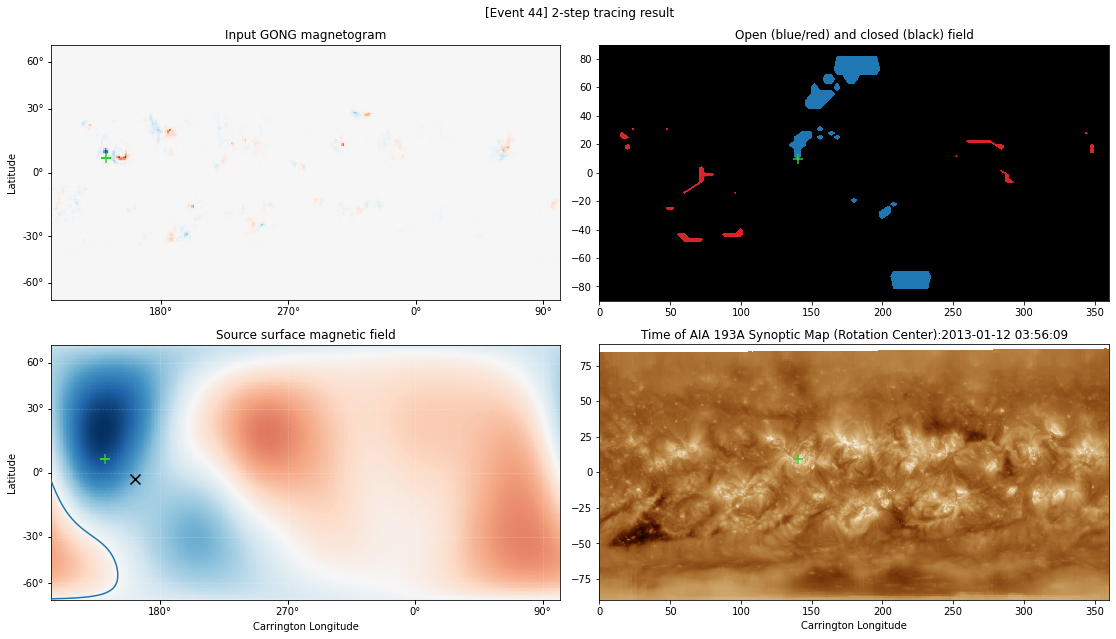

CPU times: user 7 s, sys: 647 ms, total: 7.64 s
Wall time: 7 s


In [194]:
%%time
fig = plt.figure(figsize=(15,9))
plt.subplots_adjust(wspace=0.3,hspace=0.2)

plt.suptitle(f'[Event {i_event:02d}] 2-step tracing result')

m = pfss_in.map
ax = fig.add_subplot(2, 2, 1, projection=m)
m.plot()
ax.set_title('Input GONG magnetogram')
ax.scatter(get_lon_loc_in_plot(MFL_photosphere_lon_deg,gong_map.center.lon.value),MFL_photosphere_lat_deg+90,marker='+',color='limegreen',s=100)
ax.set_xlabel(' ')

ss_br_large = pfss_out.source_surface_br
ax = fig.add_subplot(2, 2, 3,projection=ss_br_large)
ss_br_large.plot()
ax.plot_coord(pfss_out.source_surface_pils[0])
ax.scatter(get_lon_loc_in_plot(lon_footpoint_on_SourceSurface_deg,gong_map.center.lon.value),lat_footpoint_on_SourceSurface_deg+90,marker='x',color='k',s=100)
ax.scatter(get_lon_loc_in_plot(MFL_photosphere_lon_deg,gong_map.center.lon.value),MFL_photosphere_lat_deg+90,marker='+',color='limegreen',s=100)
ax.set_title('Source surface magnetic field')
set_axes_lims(ax);

ax = fig.add_subplot(2, 2, 2,)
cmap = mcolor.ListedColormap(['tab:red', 'black', 'tab:blue'])
norm = mcolor.BoundaryNorm([-1.5, -0.5, 0.5, 1.5], ncolors=3)
pols = field_lines.polarities.reshape(2 * nsteps + 1, nsteps + 1).T
ax.contourf(np.rad2deg(lon_1d), np.rad2deg(lat_1d), pols, norm=norm, cmap=cmap)
ax.scatter(MFL_photosphere_lon_deg,
           MFL_photosphere_lat_deg,marker='+',color='limegreen',s=100)
ax.set_title('Open (blue/red) and closed (black) field')
# ax.set_aspect(0.5 * 360 / 2)

ax = fig.add_subplot(2, 2, 4)
lon = np.linspace(0,360,3600)
lat = np.linspace(-90,90,1080)
ax.pcolormesh(lon,lat,np.log(zdata),cmap='sdoaia193')
ax.scatter(MFL_photosphere_lon_deg,
           MFL_photosphere_lat_deg,marker='+',color='limegreen',s=100)
ax.set_xlabel('Carrington Longitude')
ax.set_title('Time of AIA 193A Synoptic Map (Rotation Center):'+f"{t}")

plt.tight_layout()
plt.savefig('tracing_result_figures/event%02d-tracing_result.png'%i_event,dpi=200)
plt.show();